Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


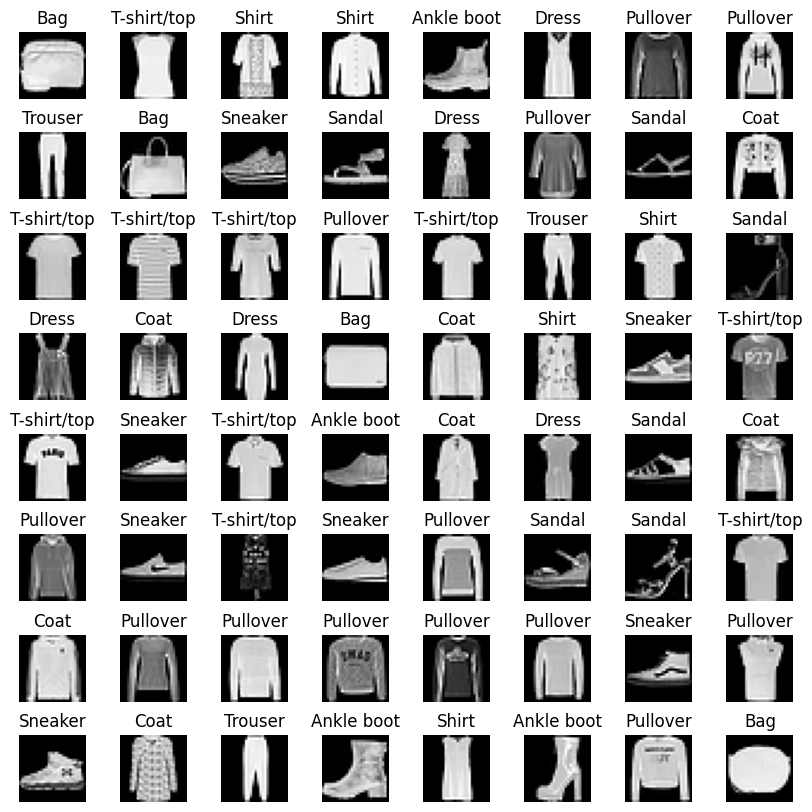

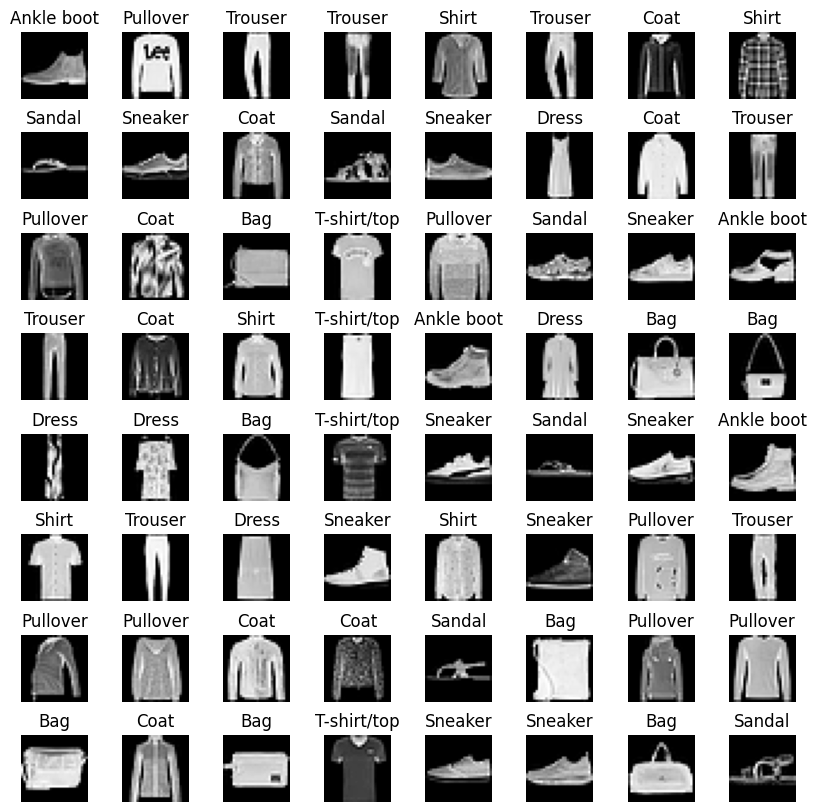

In [1]:
#1. 데이터 분석


#필요한 라이브러리 가져오기
%pip install torchvision
%pip install torchinfo
%pip install pytorchcv

import builtins
import torch
import torch.nn as nn
from torch.utils import data
import torchvision
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import glob
import os
import zipfile 

#배치 크기 설정하기 (64로 설정하여 데이터를 64 단위로 나누도록 함)
numb_batch=64

#데이터 레이블 설정하기
label= ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

#torchvision.transforms 모듈을 이용하여 이미지 변환 함수를 조합하도록 함
#torchvision.transgorms.Compose -> ToTensor() 변환 함수만을 조합하여 하나의 변환 함수로 만듦
T=torchvision.transforms.Compose([
    #이미지를 PyTorch 텐서 형식으로 변환하여 이미지 데이터를 효과적으로 처리하도록 함
    torchvision.transforms.ToTensor()
])


#FashionMNIST 데이터셋 설정하기 
#훈련 데이터셋과 검증 데이터 셋을 만듦
#minist_data라는 데이터 셋이 저장될 경로 설정
#train은 학습 데이터를 불러올지 말지의 여부
#download는 데이터셋이 해당 경로에 없으면 인터넷에서 자동으로 다운로드 하도록 설정
#transform=T 이미지 데이터를 모델에 입력하기 위해 데이터를 텐서로 변환하는 변환 함수 적용
train_data=torchvision.datasets.FashionMNIST('mnist_data', train=True, download=True,transform=T)   #훈련 데이터셋
val_data=torchvision.datasets.FashionMNIST('mnist_data',train=False,download=True,transform=T)      #검증 데이터셋


#데이터 로더 설정하기
#shuffle -> 데이터 로드 시 데이터셋 내의 샘플들을 섞을지 여부
#train_dl의 경우 shuffle 값이 True로 데이터 로더가 각 에포크마다 데이터를 섞어 모델에게 다양한 샘플을 제공하도록 설정하여 모델 학습 안정화 시키고 일반화 성늘을 향상시키는데 도움되도록 함
train_dl=torch.utils.data.DataLoader(train_data,batch_size=numb_batch,shuffle=True)
#val_dl의 경우 shuffle 값이 False로 설정함 -> val_dl은 검증 데이터셋으로 모델의 성능을 평가하는데 사용되는데 데이터셋을 섞게 되면 제대로 평가할 수 없음 즉 순서를 섞지 않고 순서대로 가져오도록 함
val_dl= torch.utils.data.DataLoader(val_data,batch_size=numb_batch,shuffle=False)


#이미지 시각화 해보기
#loader을 인자값으로 갖는 visualize_images라는 함수 선언하기
def visualize_images(loader):
    # 데이터 로더에서 이미지와 레이블을 가져오기 위해 for문을 이용함
    #images -> 이미지 데이터 , labels -> 이미지 레이블을 뜻함
    for images, labels in loader:
        #그리드가 8x8이고 전체 그림의 크기는 10,10인 이미지를 표시할 수 있는 서브 플롯 생성하기 
        #fig -> 그림 전체를 나타내는 객체 , axs -> 각각의 서브 플롯을 나타내는 배열임
        fig, axs = plt.subplots(8, 8, figsize=(10, 10))
        axs = axs.ravel()    #2차원 배열인 axs -> 1차원 배열로 만듦
        
        for i in range(len(images)):
            #imshow() -> 이미지를 시각화 함 , squeeze() -> 차원을 축소하여 필요없는 자원 제거 , cmap ='gray' -> 흑백으로 표시하도록 이미지를 그림
            axs[i].imshow(images[i].squeeze(), cmap='gray')  
            #이미지 제목 설정
            axs[i].set_title(label[labels[i].item()])  
            #데이터가 많아 축이 있으면 보기 불편한 관계로 axs[i].axis('off')를 사용하여 축을 없앰
            axs[i].axis('off')  
        plt.subplots_adjust(wspace=0.5, hspace=0.5) #간격 조정하기
        plt.show() 
        break


# visualize_images 함수를 사용하여 훈련 데이터셋 이미지 시각화하기
visualize_images(train_dl)


#visualize_images 함수를 사용하여 검증 데이터셋 이미지 시각화하기
visualize_images(val_dl)

In [2]:
# < 위 코드 결과 해석 >
# 위 이미지는 FashionMNIST 데이터셋을 사용하여 훈련데이터셋과 검증 데이터셋을 설정한 것을 이미지로 시각화 한 것이다.
# 맨 위 첫번째 이미지는 훈련 데이터셋을 시각화 한 것이다.
# 두 번째 이미지는 검증 데이터셋을 시각화 한 것이다. 

In [3]:
#2. 모델 구축 및 훈련-(1) 신경망 모델 정의 및 구조 요약해서 출력하기

#필요한 라이브러리 구축
%pip install torchsummary
import torch
import torch.nn as nn
from torchsummary import summary #모델의 요약 정보 출력하는 데 사용함

#간단한 cnn 모델 정의하기
#nn.module을 상속받는 cnn 클래스 정의하기
class cnn_definition(nn.Module):
    #클래스의 생성자 메서드 정의하기
    def __init__(self):
        super(cnn_definition, self).__init__()
        #합성곱 레이어
        #in_channels -> 입력 채널 수 의미 , out_channels -> 출력 채널 수 의미, kernel_size -> 커널 크기 의미
        self.conv_layer = nn.Conv2d(in_channels=1,out_channels=16,kernel_size=3, stride =1, padding=1)
        #풀링 레이어 (max pooling과 average pooling중 max pooling 이용함)
        #kenel_size와 stride를 각각 2로 설정 -> 2x2영역에서 max값 구함
        self.pool_layer= nn.MaxPool2d(kernel_size=2, stride=2)
        #평탄화 작업하기
        self.flatten = nn.Flatten() 
        #선형 레이어 정의하기
        self.linear_layer=nn.Linear(16*14*14,10)


    #순전파를 정의하는 메서드 
    def forward(self, x):
         # 입력 x의 차원이 예상치 못한 추가 차원을 포함하는 경우, 해당 차원을 제거함
        if x.dim() == 5 and x.size(2) == 1: 
            x = x.squeeze(2)
        x = nn.functional.relu(self.conv_layer(x)) # 정의된 컨볼루션 레이어를 입력 x에 적용한 후 ReLU 활성화 함수를 적용함
        x = self.pool_layer(x) # 맥스 풀링 레이어에 x를 적용함
        x = self.flatten(x) # ReLU의 출력을 flatten 레이어를 통해 평탄화함
        x = self.linear_layer(x) 
        return x

#네트워크 인스턴스 만들기
net = cnn_definition()

#요약 정보 출력하기
summary(net,input_size=(1,1,28,28))


Note: you may need to restart the kernel to use updated packages.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
         MaxPool2d-2           [-1, 16, 14, 14]               0
           Flatten-3                 [-1, 3136]               0
            Linear-4                   [-1, 10]          31,370
Total params: 31,530
Trainable params: 31,530
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.14
Params size (MB): 0.12
Estimated Total Size (MB): 0.27
----------------------------------------------------------------


In [4]:
# < 위 코드 결과 해석 >
# Layer -> 모델의 각 레이어 이름과 타입을 나타낸 것이다. Conv2d-1은 합성곱 레이어를 나타낸 것이고 MaxPool2d-2는 맥스 풀링 레이어를 나타낸다. 그리고 Flattern-3은 평탄화 레이어와 Linear-4은 선형 레이어를 나타나도록 한 것이다.
# Output Shape -> 각 레이어의 출력 형태를 보여준다. 예를 들어 Conv2d-1의 경우 16개의 채널을 가지며 28x28의 크기를 출력을 갖는다는 것을 의미한다.
# Param -> 각 레이어의 파라미터 수를 표시한다. 레이어에서 조정되는 가중치 및 편향의 총 개수를 나타낸다. 
# Total params -> 총 모델의 파라미터 수를 표시함
# Trainable params -> 모델에서 학습 가능한 파라미터 수를 표시한다.
# Non-trainable params -> 학습되지 않는 파라미터 수를 표시한다.

In [5]:
#2. 모델 구축 및 훈련-(2) 모델 컴파일하고 적절한 손실 함수와 최적화 알고리즘 선택하기 및 훈련 데이터를 사용하여 모델 훈련  시키고 훈련 과정에서의 손실과 정화도 모니터링하기


import torch 
from torch import optim
import torch.nn.functional as F

# train 함수 정의하기
# 매개변수로 모델과 훈련 데이터 로더, 검증 데이터 로더 , 에폭 수를 받음
def train(model, train_dl, val_dl, epochs=5):
    # 사용 가능한 경우 CUDA를 사용하고 그렇지 않을 경우 cpu 사용하도록 함
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
    # 모델을 해당 장치로 이동하기
    model.to(device) 
    # Adam 최적화 도구를 사용 -> 모델의 매개변수를 최적함
    # 학습률은 0.001로 설정
    optimizer = optim.Adam(model.parameters(), lr=0.001) 
    # 다중 클래스 분류를 위한 크로스 엔트로피 손실 함수를 사용함
    criterion = torch.nn.CrossEntropyLoss() 
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    

    try:
        for epoch in range(epochs):
            model.train()   # 모델을 학습 모드로 설정함
            train_loss, train_correct, train_total = 0, 0, 0

            for data, target in train_dl: 
                # 훈련 데이터 로더에서 데이터와 타겟을 가져와서 반복함
                # 데이터와 타섹을 지정된 device로 이동시킴
                data, target = data.to(device), target.to(device)
                # 최적화 도구의 그래디언트 0으로 초기화 시킴
                optimizer.zero_grad()
                # 모델에 데이터를 전달하여 출력 얻음
                output = model(data)
                
                # 출력이 없을 경우 -> 에러 메세지 뜨게 함
                if output is None:
                    print("Warning: Model output is None.")
                    continue
                
                # 출력과 타겟 사이의 손실을 계산함
                loss = criterion(output, target) 
                # 손실이 없을 경우 -> 에러 메세지 뜨게 함
                if loss is None:
                    print("Warning: Loss computation returned None.")
                    continue
                
                # 역전파 이용하여 그래디언트 계산
                loss.backward()
                optimizer.step()  # 최적화 도구 사용하여 모델의 매개변수 업데이트 하기
                
                # 훈련 손실을 더하기
                train_loss += loss.item() 
                # 모델의 출력에서 클래스 예측하기
                _, predicted = torch.max(output.data, 1) # 모델 출력에서 클래스 예측하기
                train_total += target.size(0)  # 훈련 중인 데이터 수 업데이트 하기 
                #올바르게 예측된 데이터 수 증가시키기
                train_correct += (predicted == target).sum().item()
            
            #훈련 손실을 전체 데이터셋 크기로 나누기 -> 평균 손실 구하기
            train_loss /= len(train_dl.dataset)
            # 훈련 정확도 백분율로 계산하기
            train_acc = 100. * train_correct / train_total
            # 훈련 데이터셋에 대한 손실과 정확도 저장하기
            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            
            # 모델을 평가 모드로 설정하기
            model.eval()
            val_loss, val_correct, val_total = 0, 0, 0
            with torch.no_grad():
                for data, target in val_dl:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    if output is None:
                        print("Warning: Model output is None during evaluation.")
                        continue
                    
                    loss = criterion(output, target)
                    if loss is None:
                        print("Warning: Loss computation returned None during evaluation.")
                        continue
                    
                    # 검증 데이터에 대한 총 손실 증가시키기
                    val_loss += loss.item()
                    # 모델의 출력에서 클래스 예측하기
                    _, predicted = torch.max(output.data, 1)
                    val_total += target.size(0)
                    # 검증 데이터셋에서 올바르게 예측된 데이터 수 증가시키
                    val_correct += (predicted == target).sum().item()
            
            # 평균 검증 손실 계산하기
            val_loss /= len(val_dl.dataset)
            #백분율로 계산하기
            val_acc = 100. * val_correct / val_total
            # 현재 에폭에서의 검증 손실
            history['val_loss'].append(val_loss)
            # 현재 에폭에서의 검증 정확도
            history['val_acc'].append(val_acc)
            
            print(f'Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        
    except Exception as e: # 에러가 발생할 경우 처리하는데 에러 발생 시 해당 에러 메시지를 출력하고 None을 반환
        print(f"An error occurred: {e}")
        return None
    
    return history # 학습과 테스트 과정에서의 손실과 정확도를 기록한 history 딕셔너리를 반환

Epoch 1/5: Train Loss: 0.0075, Train Acc: 83.34%, Val Loss: 0.0060, Val Acc: 86.58%
Epoch 2/5: Train Loss: 0.0053, Train Acc: 88.34%, Val Loss: 0.0055, Val Acc: 87.76%
Epoch 3/5: Train Loss: 0.0047, Train Acc: 89.36%, Val Loss: 0.0051, Val Acc: 88.60%
Epoch 4/5: Train Loss: 0.0044, Train Acc: 90.09%, Val Loss: 0.0050, Val Acc: 88.42%
Epoch 5/5: Train Loss: 0.0042, Train Acc: 90.63%, Val Loss: 0.0048, Val Acc: 89.41%


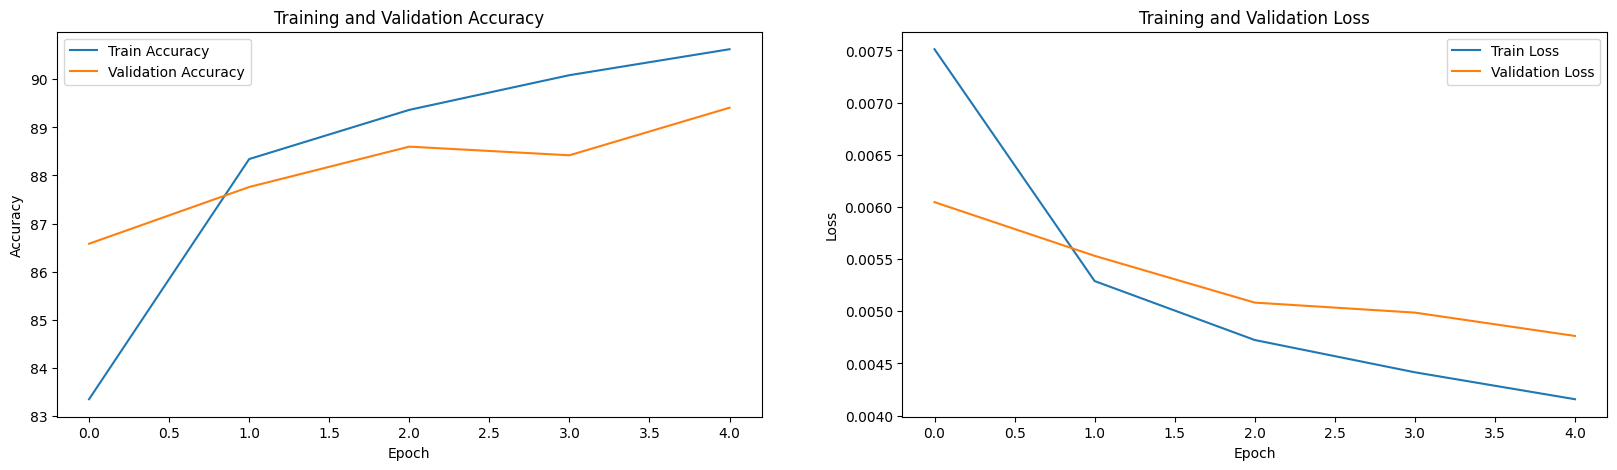

In [6]:

# train 함수 사용하여 모델 훈련하고 그 떄 발생하는 손실과 정확도를 포함하는 hist 변수에 저장
hist = train(net,train_dl,val_dl,epochs=5)

#hist가 None 인지 확인하기
if hist is None:
    print("Training did not return any history.")
else:
    # hist 에서 훈련 및 검증 손실과 정확도 데이터 추출하여 각각의 변수에 저장하기
    train_loss = hist['train_loss']
    train_acc = hist['train_acc']
    val_loss = hist['val_loss']
    val_acc = hist['val_acc']

    # 그래프 그리기
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()


    
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

In [7]:
# < 위 코드 결과 해석 >
# 위 그래프는 각 에폭에서의 훈련 및 검증 손실과 정확도를 시각화 한 것이다. 
# 이를 통해 훈련 과정을 시각적으로 확인 가능하다.
# 첫 번쨰 그래프는 훈련 및 검증 정확도를 나타내고 두 번쨰 그래프는 훈련 및 검증 손실을 나타낸다. 
# 훈련 및 검증 정확도 그래프는 에폭이 증가함에 따라 정확도가 높아지는 것을 확인 할 수 있다.
# 훈련 및 검증 손실 그래프는 에폭이 증가함에 따라 손실이 낮아지는 것을 확인 할 수 있다.

final test accuracy: 89.41%


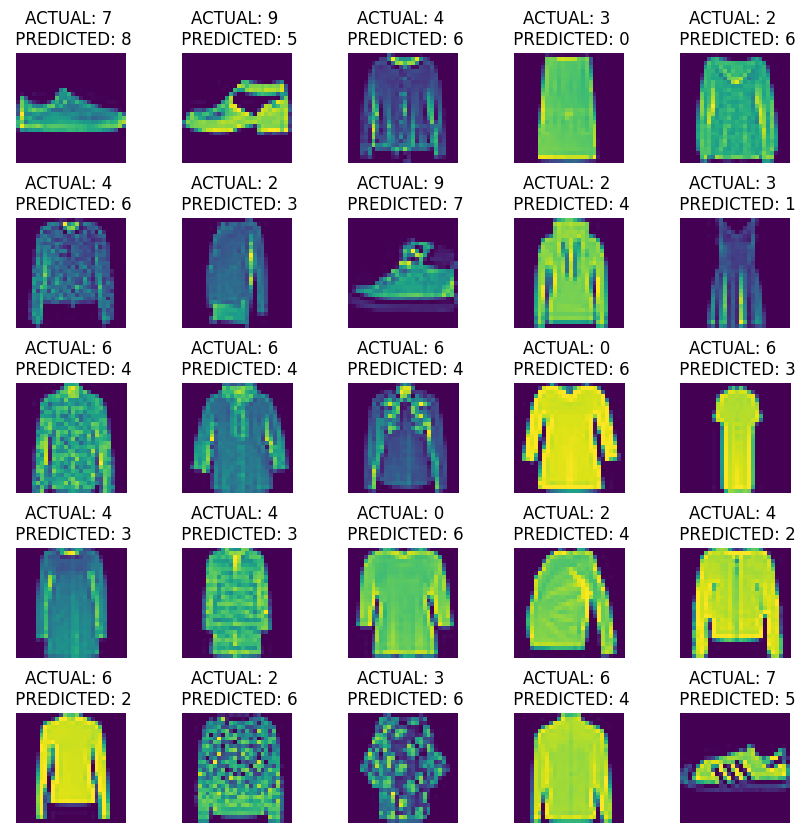

Image 1: ACTUAL: 7, PREDICTED: 8
Image 2: ACTUAL: 9, PREDICTED: 5
Image 3: ACTUAL: 4, PREDICTED: 6
Image 4: ACTUAL: 3, PREDICTED: 0
Image 5: ACTUAL: 2, PREDICTED: 6
Image 6: ACTUAL: 4, PREDICTED: 6
Image 7: ACTUAL: 2, PREDICTED: 3
Image 8: ACTUAL: 9, PREDICTED: 7
Image 9: ACTUAL: 2, PREDICTED: 4
Image 10: ACTUAL: 3, PREDICTED: 1
Image 11: ACTUAL: 6, PREDICTED: 4
Image 12: ACTUAL: 6, PREDICTED: 4
Image 13: ACTUAL: 6, PREDICTED: 4
Image 14: ACTUAL: 0, PREDICTED: 6
Image 15: ACTUAL: 6, PREDICTED: 3
Image 16: ACTUAL: 4, PREDICTED: 3
Image 17: ACTUAL: 4, PREDICTED: 3
Image 18: ACTUAL: 0, PREDICTED: 6
Image 19: ACTUAL: 2, PREDICTED: 4
Image 20: ACTUAL: 4, PREDICTED: 2
Image 21: ACTUAL: 6, PREDICTED: 2
Image 22: ACTUAL: 2, PREDICTED: 6
Image 23: ACTUAL: 3, PREDICTED: 6
Image 24: ACTUAL: 6, PREDICTED: 4
Image 25: ACTUAL: 7, PREDICTED: 5
Image 26: ACTUAL: 9, PREDICTED: 7
Image 27: ACTUAL: 6, PREDICTED: 2
Image 28: ACTUAL: 0, PREDICTED: 3
Image 29: ACTUAL: 0, PREDICTED: 6
Image 30: ACTUAL: 2, PR

In [8]:
#모델 평가 및 결과 분석하기-(1)  모델 평가 및 최종 정확도 보고하기


#테스트 데이터셋 이용하여 모델 평가하기 및 최종 정확도 보고하기

# evaluate_model 함수 정의하기 
#모델과 검증 데이터로더를 인자값으로 받음
def evaluate_model(model, val_dl):
    #"cuda" 사용 가능한 경우 사용 , 그렇지 않으면 "cpu" 사용함을 의미
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #model.eval로 모델 평가 모드로 들어감
    model.eval()
    correct = 0  #올바르게 분류된 이미지 수 초기화하기
    total = 0    #전체 이미지 수 초기화하기
    misclassified_images = []  #잘못 분류된 이미지 리스트 생성하기 
    misclassified_labels = []  #해당 레이블 리스트 생성하기
    predicted_labels = []      # 예측된 레이블 저장할 리스트 생성하기
    

    with torch.no_grad():
        #검증 데이터로더에서 이미지와 레이블 가져오기
        for images, labels in val_dl:
            #이미지와 레이블 device로 이동시키기
            images, labels =images.to(device), labels.to(device)
            #모델 이미지 전달 및 예측 수행하기
            outputs = model(images)
            _, predicted =torch.max(outputs.data, 1)  #출력 중 가장 높은 값 가진 클래스 선택하여 예측된 클래스 가져오기
            #전체 이미지 수 증가 및 올바르게 분류된 이미지 수 세기
            total +=labels.size(0) 
            correct +=(predicted ==labels).sum().item()
            
            #잘못 분류된 이미지, 레이블 및 예측된 레이블 저장하기
            misclassified_images.extend(images[predicted != labels])
            misclassified_labels.extend(labels[predicted != labels])
            predicted_labels.extend(predicted[predicted != labels])
    
    #정확도 측정하기
    accuracy=100 * correct / total
    print(f'final test accuracy: {accuracy:.2f}%')
    return misclassified_images, misclassified_labels, predicted_labels

misclassified_images, misclassified_labels, predicted_labels =evaluate_model(net, val_dl)

# 잘못 분류된 이미지 시각화하기
plt.figure(figsize=(10, 10)) # 이미지를 잘 보여주고 분속하기 용이하도록 figsize를 10,10로 그림의 크기를 설정함
for i in range(25): #25개의 이미지 시각화함 -> 5x5 격자에 이미지 배치함
    plt.subplot(5, 5, i + 1)
    plt.imshow(misclassified_images[i].permute(1, 2, 0).cpu()) # permute(1,2,0) 사용하여 이미지 차원 조정함
    plt.title(f'ACTUAL: {misclassified_labels[i].item()} \n PREDICTED: {predicted_labels[i].item()}') #이미지 제목 , 실제 레이블 값과 예측 레이블 표시함
    plt.subplots_adjust(wspace=0.5, hspace=0.5) # 이 문장 없이 실행을 시키면 문자열들이 겹쳐 한눈에 알아보기에 어려움이 있어 이 문장을 추가하여 간격 조정을 함
    plt.axis('off') #축 제거함 
plt.show()

# 잘못 분류된 이미지의 실제 클래스 및 예측 클래스 확인하기
for i in range(len(misclassified_images)): 
    #잘못 분류된 이미지의 실제 값과 예측된 값 이미지 시각화 밑에 텍스트로 출력하도록 함
    print(f'Image {i+1}: ACTUAL: {misclassified_labels[i].item()}, PREDICTED: {predicted_labels[i].item()}')



In [9]:
# < 위 코드 결과 해석 >
# 우선 final test accuracy 즉 최종 정확도를 출력한다.
# 이미지는 잘못 분류된 이미지를 시각화 한 것이다. 실제 레이블과 예측된 레이블이 다른 것을 이미지로 보여주기 위하여 해당 이미지와 함께 제목으로 실제 레이블과 예측한 레이블 값을 출력하도록 하였다.
# 그 후 실제 레이블과 예측된 레이블을 텍스트로 출력하여 결과를 볼 수 있도록 하였다.

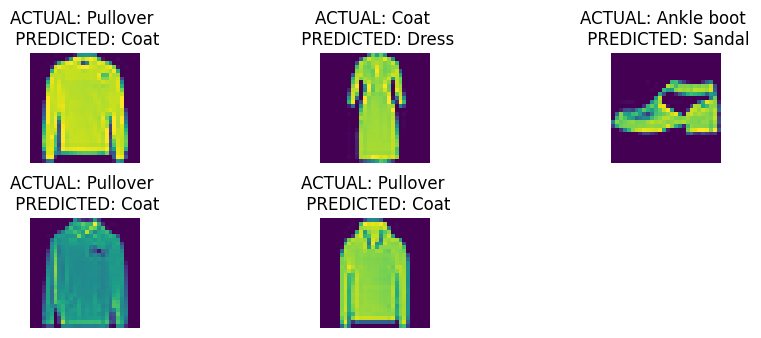

In [10]:
# 모델 평가 및 결과 분석하기-(2)  잘못된 이미지 분석하기

# 잘못된 이미지 분석하기
# 실제 라벨과 예측된 라벨 비교하여 잘못 분류된 이미지 찾기
# 잘못된 이미지 찾아내는 함수 정의하기 
# misclassified_images -> 잘못 분류된 이미지들의 리스트 , misclassified_labels -> 잘못 분류된 이미지들의 실제 레이블 리스트
# predicted_labels -> 잘못 분류된 이미지들의 예측된 라벨들의 리스트 , classes -> 이미지 분류에 사용된 클래스들의 리스트 , num_samples -> 시각화할 샘플 이미지 수 
def find_mis_img(misclassified_images,misclassifed_labels,predicted_labels,classes, num_samples=5):
    # 잘못 분류된 이미지와 라벨 가져오기
    num_misclassified= len(misclassified_images)
    # 잘못 분류된 이미지 중 무작위로 5개 (num_samples)의 인덱스 선택함
    sample = np.random.choice(num_misclassified,size=num_samples, replace=False)

    # 이미지와 라벨 시각화 하기
    # 시각화할 플롯 생성하기
    plt.figure(figsize=(10, 2*num_samples))
    # 아까 무작위로 5개의 선택한 인덱스에 대해(=sample) 이미지와 실제 레이블, 예측된 레이블 가져온 후 이를 제목 설정하여 플롯에 추가하는 동작 반복하기
    for i, index in enumerate(sample):
        # 이미지 가져오기
        image = misclassified_images[index]
        # 실제 레이블 가져오기  
        actual_label = classes[misclassified_labels[index].item()]  
        # 예측된 레이블 가져오기
        predicted_label = classes[predicted_labels[index].item()]  
        
        # 이미지 출력
        plt.subplot(num_samples, 3, i+1) 
        plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))  # np.transponse 함수 이용 -> 이미지 차원 변경하여 RGB 이미지 올바르게 표시하도록 함
        plt.axis('off') # 축 설정 x
        plt.title(f'ACTUAL: {actual_label} \n PREDICTED: {predicted_label}') # 제목은 실제 레이블과 예측된 레이블이 나타나도록 설정함
        plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.show()

# 잘못 분류된 이미지 분석 및 시각화하기
find_mis_img(misclassified_images, misclassified_labels, predicted_labels, label, num_samples=5)

In [11]:
# < 위 결과에 대한 해석 >
# 위 이미지는 잘못 분류된 이미지들 중 랜덤하게 추출한 인덱스 5개에 대한 이미지를 출력한 것이다.
# 긱 이미지 위에는 해당 이미지의 실제 레이블과 모델이 예측한 레이블이 함께 표시되어 비교할 수 있다. (ex) ACTUAL: shirt  PREDICTED: Pullover)
# 이렇게 하여 잘못 분류된 이미지들과 실제 레이블, 예측된 레이블을 한눈에 알아볼 수 있도록 하였다.

In [12]:
#모델 평가 및 결과 분석하기-(2) 어떤 클래스가 모델에 의해 가장 잘못 분류 되었는지 식별

#어떤 클래스가 모델에 의해 가장 잘못 분류 되었는지 식별
# 가장 잘못 분류되었는지 식별하는 identify_mis_img 함수 정의하기
# misclassified_labels -> 잘못 분류된 이미지들의 레이블  classes -> 클래스
def identify_mis_img(misclassified_labels,classes):
    # 잘못 분류된 이미지의 수 0으로 초기화 시킴
    misclassified_counts={}

    # 잘못 분류된 이미지들의 레이블에 대해 
    for label in misclassified_labels:
        # 현재 레이블에 해당하는 클래스 이름 가져오기
        class_name = classes[label.item()]
        # 딕셔너리에 있는지 확인하기
        if class_name in misclassified_counts:
            # 있을 경우 -> 카우ㄴ트 증가
            misclassified_counts[class_name] += 1
        else:
            # 없을 경우 -> 새로운 클래스 추가 및 카운트 1로 설정
            misclassified_counts[class_name] = 1
    
    # 가장 많이 잘못 분류된 클래스 식별
    most_mis_class = max(misclassified_counts, key=misclassified_counts.get)
    # 딕셔너리에서 가장 큰 값 가지는 키 식별하기
    misclassified_count = misclassified_counts[most_mis_class] 
    return most_mis_class, misclassified_count

# 가장 잘못 분류된 클래스 식별
most_mis_class, misclassified_count = identify_mis_img(misclassified_labels, label)
print(f"The most misclassified class : '{most_mis_class}' \ncount :  {misclassified_count} misclassified images.")

The most misclassified class : 'Shirt' 
count :  352 misclassified images.


In [13]:
# < 위 코드 결과 해석 >
# 위 결과는 가장 잘못 분류된 클래스를 출력하고 그 이미지에 대한 수를 출력한다.